# IBCM model for fluctuating inputs

## Model to consider
I consider a feedforward network of IBCM  neurons. Each IBCM neuron has two input connections, represented by the connectivity vector $\vec{m}_i = (m^1_i, m^2_i)$. Its activation upon stimulation is given by $c = \vec{m}_i \cdot \vec{x}$, where $\vec{x}$ is a two-dimensional input vector. Its inhibited activity is 

$$ \bar{c}_i = c_i - \eta \sum_{j \neq i} c_j \quad \mathrm{where} \, \, c_i(t) = \vec{m}_i(t) \cdot \vec{x}(t)  \, \,$$

The update equation of each IBCM neuron's weights uses this inhibited activity:

$$ \dot{m}_i = \mu \left[ \bar{c}_i(\bar{c}_i - \bar{\Theta}_{m, i}) \vec{x} - \eta \sum_{j \neq i} \bar{c}_j(\bar{c}_j - \bar{\Theta}_{m, j}) \vec{x} \right]  \quad \mathrm{where} \, \, \bar{\Theta}_m = \mathbb{E}[\bar{c}_i^2] $$

The parameter $\eta$ is the coupling strength. 

The expectation value is taken over a time window $T$, which should be much larger than the fluctuation time scale of the input $\tau$, but also much smaller than the $\vec{m}$ evolution time scale $\frac{1}{\mu}$. To begin with, I just average computationally, but eventually, for realism of the model, I will compute $\Theta$ with an auxiliary variable that performs a time-averaging by having a slow decay rate. 

In [2]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sys
if ".." not in sys.path:
    sys.path.insert(1, "..")

from utils.statistics import estimate_empirical_covariance

In [3]:
%matplotlib inline

In [4]:
def integrate_ibcm_network(m_init, update_bk, bk_init, bk_params, tmax, dt, 
                   learnrate, seed=14345124, noisetype="normal", tavg=100, coupling=0.1):
    """ Integrate the IBCM equation when the input updated by the derivative
    function update_bk, which takes pre-generated noise and bk_params. 
    The intended usage here is for an input that is a linear 
    combination of two LI vectors, and the proportion of each 
    component in the input fluctuates around 1/2 following a 
    Ornstein-Uhlenbeck process with rate specified in bk_params. 
    
    Args:
        m_init (np.ndarray): 2d array, shape (number neurons, number dimensions)
        update_bk (callable): function that updates the background variables and 
            the background vector
        bk_init (list of two 1d np.ndarrays): [bk_vari_init, bk_vec_init]
            bk_vari_init (np.ndarray): 1d array of background random variables
            bk_vec_init (np.ndarray): initial background vector, must have size n_dim
        bk_params (list): list of parameters passed to update_bk (3rd argument)
        tmax (float): max time
        dt (float): time step
        learnrate (float): kinetic learning rate \mu in the IBCM equation
        seed (int): seed for the random number generator
        noisetype (str): either "normal" or "uniform"
        tavg (float): default: 10
        coupling (float): eta, between 0 and 1
   
    Returns:
        tseries, m_series, bk_series, c_series, cbar_series, w_series, bkvec_series
    """
    n_neu = m_init.shape[0]  # Number of neurons
    n_dim = m_init.shape[1]
    bk_vari_init, bk_vec_init = bk_init
    n_bkvari = bk_vari_init.shape[0]
    assert n_dim == bk_vec_init.shape[0], "Mismatch between dimension of m and background"
    
    rng = np.random.default_rng(seed=seed)
    tseries = np.arange(0, tmax, dt)
    tavg = int(round(tavg / dt))  # Number of time steps over which to average
    
    # Containers for the solution over time
    bk_series = np.zeros([tseries.shape[0], n_bkvari])
    m_series = np.zeros([tseries.shape[0], n_neu, n_dim])
    cbar_series = np.zeros([tseries.shape[0], n_neu])
    c_series = np.zeros([tseries.shape[0], n_neu])
    bkvec_series = np.zeros([tseries.shape[0], n_dim])  # Input vecs, convenient to compute inhibited output
    
    ## Initialize running variables, separate from the containers above to avoid side effects. 
    c = np.zeros(n_neu)  # un-inhibited neuron activities
    cbar = np.zeros(n_neu)  # inhibited neuron activities
    cbar2_avg = np.zeros(n_neu)  # Average inhibited neuron activities squared, initialized at zero
    bk_vari = bk_vari_init.copy()
    bkvec = bk_vec_init.copy()
    m = m_init.copy()
    
    # Initialize neuron activity with m and background at time zero
    c = m.dot(bkvec)
    cbar = c - coupling*(np.sum(c) - c)  # -c to cancel the subtraction of c[i] itself
    cbar2_avg = cbar**2
    
    # Store back some initial values in containers
    c_series[0] = c
    cbar_series[0] = cbar
    bk_series[0] = bk_vari
    m_series[0] = m_init
    bkvec_series[0] = bkvec
    
    # Generate N(0, 1) noise samples in advance
    if (tseries.shape[0]-1)*n_dim > 1e7:
        raise ValueError("Too much memory needed; consider calling multiple times for shorter times")
    if noisetype == "normal":
        noises = rng.normal(0, 1, size=(tseries.shape[0]-1, n_bkvari))
    elif noisetype == "uniform":
        noises = rng.random(size=(tseries.shape[0]-1, n_bkvari))
    else:
        raise NotImplementedError("Noise option {} not implemented".format(noisetype))
    
    t = 0
    for k in range(0, len(tseries)-1):
        t += dt  
        ### IBCM neurons
        # Update first their synaptic weights m to time k+1 before updating c, cbar, 
        # because dm/dt depends on c, cbar, cbar2_avg at time k
        # Phi function for each neuron
        phiterms_vec = cbar * (cbar - cbar2_avg)
        # Now, careful with broadcast: for each neuron (dimension 0 of m and cbar), we need a scalar element
        # of phiterms_vec times the whole bkvec, for dimension 1 of m. 
        # This can be done vectorially with a dot product (n_neu, 1)x(1, n_components)
        rhs_scalar = phiterms_vec - coupling*(np.sum(phiterms_vec) - phiterms_vec)
        # Euler integrator and learning rate
        m = m + learnrate*dt*rhs_scalar[:, np.newaxis].dot(bkvec[np.newaxis, :])
        
        # Store the updated synaptic weights
        m_series[k+1] = m
        
        # Now, update to time k+1 the threshold (cbar2_avg) using cbar at time k
        # to be used to update m in the next time step
        cbar2_avg = cbar2_avg + (cbar*cbar - cbar2_avg)/tavg * dt
        # This Euler scheme could cause numerical stability problems if dt is too large, 
        # or tavg too small, or the average vector too large. 
        
        # Update background to time k+1, to be used in next time step
        bkvec, bk_vari = update_bk(bk_vari, bk_params, noises[k], dt)
        bk_series[k+1] = bk_vari
        bkvec_series[k+1] = bkvec
        
        # Lastly, compute activity of IBCM neurons at next time step, k+1, 
        # with the updated background and synaptic weight vector m
        # Compute un-inhibited activity of each neuron with current input (at time k)
        c = m.dot(bkvec)
        c_series[k+1] = c
        cbar = c - coupling*(np.sum(c) - c)  # -c to cancel the subtraction of c[i] itself
        # np.sum(c) is a scalar and c a vector, so it broadcasts properly. 
        cbar_series[k+1] = cbar  # Save activity of neurons at time k+1
        
        # IF we hit some nan
        if np.any(np.isnan(cbar)):
            print("Last two m values, neuron 0:", m_series[k, 0], m_series[k+1, 0])
            print("Last threshold value:", cbar2_avg)
            print("Last two cbar values:", cbar_series[k], cbar_series[k+1])
            print("Last two c values:", c_series[k], c_series[k+1])
            raise ValueError("Hit infinite values for some reason at iteration " + str(k))
        
    return tseries, m_series, bk_series, c_series, cbar_series, bkvec_series

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/xk/d13rqg5s4rj4gvl0myjd0xbr0000gq/T/ipykernel_42594/1128037849.py:3: SyntaxWarning: invalid escape sequence '\m'
  """ Integrate the IBCM equation when the input updated by the derivative


# Fluctuating mixture
To have multiple input components fluctuating realistically, we write the input as
$$ \vec{x}(t) = \sum_{\alpha=1}^K \nu_\alpha \vec{x}_\alpha $$
where the $\nu_\alpha$ are random variables with some correlation, to mimick the turbulent flow that carries all odorants together. Ideally, they would follow the distributions derived in (Celani, Villermaux and Vergassola 2014), but those are a bit tricky to simulate. A good approximation would be a multivariate log-normal distribution with a strong correlation between components; that's easy to simulate with a multivariate linear Fokker-Planck equation, converted to a Langevin equation for numerical purposes. 

### General case of the Ornstein-Uhlenbeck process
The multivariate Langevin equation for the Ornstein-Uhlenbeck process is:

$$ d\vec{x} = -A \vec{x}(t) dt + B dW(t) $$

where $\frac{dW}{dt} = \vec{\eta}(t)$, a vector of gaussian white noise (independent components), $A$ and $B$ are matrices. Assume the matrix $A$ is normal and can be diagonalized as $A = U D u^\dagger$, $D = \mathrm{diag}(\lambda^1, ..., \lambda^n)$. For a deterministic initial condition $\vec{x}(t_0) = \vec{x}_0$, the general solution is that $\vec{x}(t)$ follows a multivariate normal distribution, with mean and variance given by

$$ \langle \vec{x}(t) \rangle = U\mathrm{e}^{-D(t-t_0)}U^{\dagger} \vec{x}_0 $$
$$ \langle \vec{x}(t) \vec{x}(t)^T \rangle = U J(t, t_0) U^\dagger $$

where the components of $J$ are 

$$ J^{ij}(t, t_0) = \left(\frac{U^\dagger B B^T U}{\lambda^i + \lambda^j} \right)^{ij} \left(1 - e^{-(\lambda^i + \lambda^j)(t - t_0)}  \right) $$


The stationary distribution of $\vec{x}$ is

$$ \vec{x}^* \sim \mathcal{N} \left(\vec{0}, U^{ik} \left(\frac{B B^T}{\lambda^k + \lambda^l} \right)^{kl} (U^\dagger)^{lj} \right) \,\, .$$

### Exact numerical simulation, general case
To simulate a realization of this process exactly, we use a trick suggested by Gillespie in the univariate case (which only works for the Ornstein-Uhlenbeck process because it's linear and gaussian). We iteratively take $\vec{x}(t)$ as the initial condition of the evolution up to $\vec{x}(t + \Delta t)$, the distribution of which is

$$ \vec{x}(t + \Delta t) \sim \mathcal{N}\left( U e^{-D \Delta t}U^\dagger \vec{x}(t) , U J(t + \Delta t, t) U^\dagger \right) $$

which can be rewritten using the following property of multivariate normal distributions: if $\vec{n} \sim \mathcal{N}(\vec{0}, \mathbb{1})$, then $\vec{x} = \vec{\mu} + \Psi \vec{n} \sim \mathcal{N}(\vec{\mu}, \Psi \Psi^T)$ ($\Psi$ is the Cholesky decomposition of the desired covariance matrix). This property is easily demonstrated by computing $\langle \vec{x} \rangle$ and $\langle \vec{x} \vec{x}^T \rangle$ and using the linearity of multivariate normal distributions. For our update rule, this gives

$$ \vec{x}(t + \Delta t) = U e^{-D \Delta t}U^\dagger \vec{x}(t) + \mathrm{Chol}\left[U J(t + \Delta t, t) U^\dagger \right] \cdot \vec{n} $$

where $\vec{n}$ is a vector of standard normal(0, 1) samples. The matrices $U e^{-D \Delta t}U^\dagger$ and $\mathrm{Chol}\left[U J(t + \Delta t, t) U^\dagger \right]$ can be computed only once and applied repeatedly to the $\vec{x}(t)$ obtained in sequence and the $\vec{n}$ drawn at each iteration. The Cholesky decomposition of $UJU^\dagger$ is not obviously expressed in terms of $B$, because the possibly different $\lambda^i$ values mix up components. 


### Simple case and exact simulation of it
If $A$ is diagonal, the $U$ matrices are just identity matrices and disappear, but the Cholesky decomposition of $J(t + \Delta t, t)$ is still not obvious. More explicit expressions can be obtained in the simplifying case where $A$ is proportional to the identity matrix, i.e., all components of $\vec{x}$ have the same fluctuation time scale. 

Let's say that $A =  \frac{1}{\tau} \mathbb{1}$, where $\tau$ is the fluctuation time scale ($\lambda^i = \tau \,\, \forall i$). Then, the matrix $J$ simplifies to 

$$J(t, t_0) = \frac{\tau}{2}\left(1 - e^{-2(t - t_0)/\tau} \right)  BB^T  $$

and its Cholesky decomposition is simply $\sqrt{\frac{\tau}{2}\left(1 - e^{-2(t - t_0)/\tau} \right) } B$. Hence, the distribution of $\vec{x}(t)$ at any time since $t_0$ (deterministic initial condition $\vec{x}_0$) is

$$ \vec{x}(t) \sim \mathcal{N} \left(e^{-(t-t_0)/\tau} \vec{x}_0, \frac{\tau}{2}\left(1 - e^{-2(t - t_0)/\tau} \right)  BB^T  \right) $$

The stationary distribution is simply the above with the exponential factors set to 0. The update rule from $\vec{x}(t)$ to $\vec{x}(t + \Delta t)$ to simulate a realization of the process is nicer as well:

$$ \vec{x}(t + \Delta t) = e^{-\Delta t / \tau} \vec{x}(t) + \sqrt{\frac{\tau}{2} \left(1 - e^{-2\Delta t/\tau}  \right)} B \cdot \vec{n} $$

where $\vec{n} \sim \mathcal{N}(\vec{0}, \mathbb{1})$ is a vector of independent standard normal samples.

As before, we can compute once the (scalar) factor $e^{-\Delta t / \tau}$ and the . This is exact for any $\Delta t$, there is no increase in accuracy by decreasing $\Delta t$. You just choose the $\Delta t$ resolution at which you want to sample the realization of the process. 

### Symmetric choices for correlations
We want all pairs of $\nu_\alpha$ to have the same correlation. More specifically, we want to force a Pearson correlation coefficient of $0 < \rho < 1$ between any pair of $\nu$s. We suppose all background components have the same individual variance $\sigma^2$. The corresponding covariance matrix we want for the steady-state distribution is

$$ \Sigma = \sigma^2 \begin{pmatrix}
    1 & \rho & \ldots & \rho \\
    \rho & 1 & \ldots & \rho \\
    \ldots & \ldots & \ldots & \ldots \\
    \rho & \rho & \ldots & 1
\end{pmatrix} $$

If we apply Cholesky decomposition to get $\Sigma = \Psi \Psi^T$, then $\sqrt{\tau/2} B = \Psi$, since the steady-state covariance of the Ornstein-Uhlenbeck process is, in this simplified case, $\frac{\tau}{2} BB^T$. The $M_B$ coefficient in the update rule is then

$$ M_B = \sqrt{\tau/2(1 - e^{-2 \Delta t/\tau})}B = \sqrt{(1 - e^{-2 \Delta t/\tau})} \Psi $$

The other coefficient is just

$$ M_A = e^{-\Delta t / \tau} \mathbb{1} $$

In [5]:
# Function to update the fluctuating background variable
def update_ou_kinputs(nu_bk, params_bk, noises, dt):
    """ 
    Update a background made of L odorants with concentrations combined linearly:
        x(t) = \sum_{\alpha} \nu_{\alpha} x_{\alpha}
    The concentrations nu_alpha fluctuate according to a multivariate
    Ornstein-Uhlenbeck process with some correlation between them. The general update rule is of the form
        \vec{\nu}(t + dt) = M_A \vec{\nu}(t) + M_B \vec{n}
    where M_A and M_B are related to the matrix coefficients A and B in the Langevin equation
    as indicated above (exp factors and Cholesky decomposition), and \vec{n} is a vector of 
    independent normal(0, 1) samples. 
    This function is agnostic to A and B and just requires the overall matrix coefficients 
    in front of of x(t) and \vec{n} in the update rule. 
    
    Args:
        nu_bk (np.ndarray): array of length K, containing concentrations nu_i 
            of odorants in the background
        params_bk (list of arrays): mateA, matJB, vecs_nu, means_nu: matrices of shape (K, K)
            involved in the update rule and matrix of background component vectors x_{\alpha}, shape (K, d)
            where d is the number of dimensions. Each row is a different component. 
            Also a 1d array of the mean values of the nu variables. They are simulated with zero mean
            and their average is added before the background is computed
        noises: 1d array of pre-generated normal(0, 1) samples, one per component in nu_bk
    """
    mateA, matJB, vecs_nu, means_nu = params_bk
    nu_bk_new = np.dot(mateA, nu_bk) + np.dot(matJB, noises)
    # Update background vector, putting back the mean value of the nu's
    bkvec = np.squeeze(np.dot((nu_bk+means_nu)[np.newaxis, :], vecs_nu))
    
    return bkvec, nu_bk_new

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xk/d13rqg5s4rj4gvl0myjd0xbr0000gq/T/ipykernel_42594/457099487.py:3: SyntaxWarning: invalid escape sequence '\s'
  """


# Run a simulation
With the parameter defined as global variables below.

In [6]:
### General simulation parameters
n_dimensions = 3
n_components = 3
n_neurons = 32

# Simulation times
duration = 160000.0
deltat = 1.0
learnrate = 0.0025
tau_avg = 150
coupling_eta = 0.05 / n_neurons

# Initial synaptic weights: small positive noise near origin
rgen_meta = np.random.default_rng(seed=92347287)
init_synapses = 0.1*rgen_meta.random(size=[n_neurons, n_dimensions])

# Choose three LI vectors in (+, +, +) octant
back_components = 0.1*np.ones([n_components, n_dimensions])
for i in range(n_components):
    if i < n_dimensions:
        back_components[i, i] = 0.8
    else:
        back_components[i, i % n_dimensions] = 0.8 - i
    # Normalize
    back_components[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2))

# Initial background vector and initial nu values
averages_nu = np.ones(n_components) / np.sqrt(n_components)
init_nu = np.zeros(n_components)
init_bkvec = np.squeeze(averages_nu[np.newaxis, :].dot(back_components))
# nus are first in the list of initial background params
init_back_list = [init_nu, init_bkvec]

## Compute the matrices in the Ornstein-Uhlenbeck update equation
# Update matrix for the mean term: 
# Exponential decay with time scale tau_nu over time deltat
tau_nu = 2.0  # Fluctuation time scale of the background nu_alphas (same for all)
update_mat_A = np.identity(n_components)*np.exp(-deltat/tau_nu)

# Steady-state covariance matrix
sigma2 = 0.09
correl_rho = 0.3
steady_covmat = correl_rho * sigma2 * np.ones([n_components, n_components])  # Off-diagonals: rho
steady_covmat[np.eye(n_components, dtype=bool)] = sigma2  # diagonal: ones

# Cholesky decomposition of steady_covmat gives sqrt(tau/2) B
# Update matrix for the noise term: \sqrt(tau/2(1 - exp(-2*deltat/tau))) B
# The sqrt(tau/2) is already included in the Cholesky decomposition
psi_mat = np.linalg.cholesky(steady_covmat)
update_mat_B = np.sqrt(1.0 - np.exp(-2.0*deltat/tau_nu)) * psi_mat

back_params = [update_mat_A, update_mat_B, back_components, averages_nu]

In [7]:
sim_res = integrate_ibcm_network(init_synapses, update_ou_kinputs, init_back_list, back_params, duration, deltat, 
                       learnrate, seed=98743877, noisetype="normal", tavg=tau_avg, coupling=coupling_eta)

t_ser, m_ser, bk_ser, c_ser, cbar_ser, bkvec_ser = sim_res

In [8]:
np.argmin(np.isfinite(c_ser), axis=0)
np.argmin(np.isfinite(cbar_ser), axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### First, check that the $\nu$s have a multivariate normal distribution
with the proper parameters (covariance matrix and zero mean – remember they are simulated with zero mean). 

The above looked fine when I tested it, no need to check anymore. 

### Second, check the trajectories of $\vec{m}$ vectors

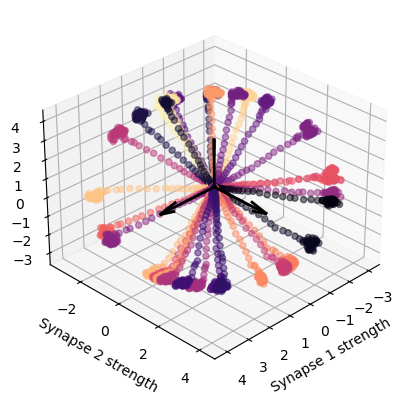

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a few points for each neuron
trst = 150
skp = 2000
ax.plot(0, 0, 0, color="k", marker="o", ls="none", ms=12)
colors = sns.color_palette("magma", n_colors=n_neurons)
for i in range(n_neurons):
    ax.scatter(m_ser[trst::skp, i, 0], m_ser[trst::skp, i, 1], m_ser[trst::skp, i, 2], 
               alpha=0.5, color=colors[i], label="Neuron {}".format(i))

# Annotate with vectors representing the odor components
orig = np.zeros([n_dimensions, n_components])
xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
scale = 3
vecs = back_components.copy()
for i in range(n_components):
    vecs[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2)) * scale
ax.quiver(*orig, *(vecs.T), color="k", lw=2.0)
ax.view_init(azim=45, elev=30)    
ax.set(xlabel="Synapse 1 strength", 
      ylabel="Synapse 2 strength", 
      zlabel="Synapse 3 strength")
# ax.view_init(azim=45, elev=140)
# ax.legend()
#fig.savefig("figures/three_odors/neurones_ibcm_fond_gaussien_3_odeurs.png", 
#            transparent=True, bbox_inches="tight", dpi=400)
plt.show()
plt.close()

### Time series of each component of each neuron

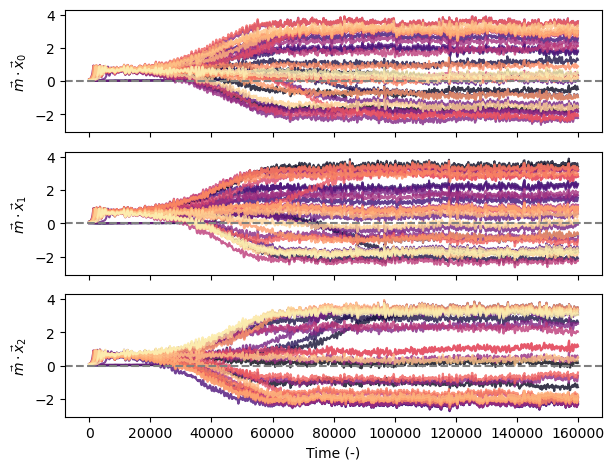

In [10]:
# Time series of the projection of each neuron on each component. 
# One plot per component. 
fig, axes = plt.subplots(n_components, sharex=True, sharey=True)
axes = axes.flatten()
skp = 100
colors = sns.color_palette("magma", n_colors=n_neurons)
for i in range(n_components):
    for j in range(n_neurons):
        m_comp_ser = m_ser[:, j].dot(back_components[i])
        axes[i].plot(t_ser[::skp], m_comp_ser[::skp], label="Neuron {}".format(j), color=colors[j], alpha=0.8)
    axes[i].set_ylabel(r"$\vec{m} \cdot \vec{x}_{"+str(i)+"}$")
    axes[i].axhline(0, ls="--", color="grey")
axes[-1].set_xlabel("Time (-)")
#axes[0].legend(ncol=n_neurons//4, fontsize=8, loc="upper left")
fig.tight_layout()
plt.show()
plt.close()

In [11]:
# Angle between average vector and neurons' m
# Suspecting this is roughly constant: 
# m steady-states fall on a cone at one standard deviation away from the average
transient = 40000
steady_m = np.mean(m_ser[transient:], axis=0)
mean_back = np.sum(back_components, axis=0)/n_components
cosines = steady_m.dot(mean_back) / np.sqrt(np.sum(steady_m**2, axis=1) * np.sum(mean_back**2))
print(cosines)

[0.20660853 0.20739835 0.30201728 0.21580564 0.27395898 0.20996838
 0.20834308 0.20244148 0.2160976  0.21454193 0.25562454 0.21081416
 0.20867371 0.20480462 0.20730595 0.21330563 0.20980937 0.20253208
 0.2118383  0.22657851 0.25935938 0.20690933 0.20815757 0.20455184
 0.20289902 0.22521264 0.20625075 0.21619945 0.21026479 0.21497346
 0.2128542  0.21246815]


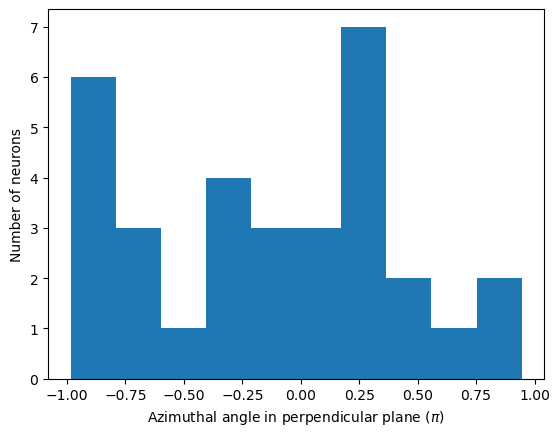

In [12]:
# Distribution of angles in the plane perpendicular to steady_m
steady_m_perpendicular = steady_m - (steady_m.dot(mean_back) / np.sum(mean_back**2)).reshape(-1, 1) * mean_back.reshape(1, 3)
# Use two of the three components as orthogonal basis vectors in that plane
ref_vec = back_components[0] - back_components[0].dot(mean_back) / np.sum(mean_back**2) * mean_back
ref_vec2 = back_components[1] - back_components[1].dot(mean_back) / np.sum(mean_back**2) * mean_back
ref_vec2 = ref_vec2 - ref_vec.dot(ref_vec2)/np.sum(ref_vec**2) * ref_vec
cosphi = steady_m_perpendicular.dot(ref_vec) / np.sqrt(np.sum(ref_vec**2)*np.sum(steady_m_perpendicular**2, axis=1))
sinphi = steady_m_perpendicular.dot(ref_vec2) / np.sqrt(np.sum(ref_vec2**2)*np.sum(steady_m_perpendicular**2, axis=1))
phi = np.arctan2(cosphi, sinphi) / (np.pi)
plt.hist(phi)
plt.xlabel(r"Azimuthal angle in perpendicular plane ($\pi$)")
plt.ylabel("Number of neurons")
plt.show()
plt.close()

### Analytical fixed point prediction for IBCM model
Calculations predicting a $K-2$ dimensional fixed point when $K$ background components. The two constraints satisfied at the fixed points are, in the $\rho = 0$ case, which is just a linear transformation away from the more general case (by diagonalization of the covariance matrix):
$$ \sum_{\alpha} \bar{c}_{\alpha} = \frac{1}{\langle \nu \rangle} $$
$$ \sum_{\alpha} \bar{c}_{\alpha}^2 = \frac{1}{\sigma^2} $$
where
$$ \bar{c}_{i, \alpha} = \vec{m}_{i} \cdot \vec{x}_{\alpha} - \eta \sum_{j \neq i} \vec{m}_j \cdot \vec{x}_{\alpha} $$

Hence, if I run a simulation with $\rho = 0$, or transform another simulation to eigencvector coordinates, I should find that every neuron at a fixed point satisfies these two equations. Let's try that. 

In [13]:
# Recompute the update matrices for nu when rho=0
correl_rho = 0.0
steady_covmat = correl_rho * sigma2 * np.ones([n_components, n_components])  # Off-diagonals: rho
steady_covmat[np.eye(n_components, dtype=bool)] = sigma2  # diagonal: ones

# Cholesky decomposition of steady_covmat gives sqrt(tau/2) B
# Update matrix for the noise term: \sqrt(tau/2(1 - exp(-2*deltat/tau))) B
psi_mat = np.linalg.cholesky(steady_covmat)
update_mat_B = np.sqrt(1.0 - np.exp(-2.0*deltat/tau_nu)) * psi_mat

averages_nu = np.ones(n_components) / np.sqrt(n_components)
back_params = [update_mat_A, update_mat_B, back_components, averages_nu]
# m_init, update_bk, bk_init, inhib_params, bk_params, tmax, dt, learnrate, seed=14345124, noisetype="normal", tavg=10, coupling=0.1


sim_results = integrate_ibcm_network(init_synapses, update_ou_kinputs, init_back_list,
                    back_params, duration, deltat, learnrate=learnrate, seed=75321653, 
                    noisetype="normal", tavg=tau_avg, coupling=coupling_eta)
tser, mser, nuser, cser, cbarser, bkvecser = sim_results

In [14]:
# Compute the cbars in response to each component.
transient = 80000
mean_cs_alpha = np.mean(mser[transient:], axis=0).dot(back_components.T)
mean_cbars_alpha = mean_cs_alpha*(1 + coupling_eta) - coupling_eta*np.sum(mean_cs_alpha, axis=0).reshape(1, -1)

# Average(cbar^2): need to compute series of cbars, then square, then average. 
cs_alpha = mser[transient:].dot(back_components.T)
cbars_alpha = cs_alpha*(1 + coupling_eta) - coupling_eta*np.sum(cs_alpha, axis=1, keepdims=True)
mean_cbars_alpha2 = np.mean(cbars_alpha**2, axis=0)

# Constaint 1: sum of c_alphas for each neuron
print("This should be all close to ones:", mean_cbars_alpha.sum(axis=1) * averages_nu.mean())
# Constraint 2: sum of c_alphas^2 for each neuron, copmared to 1/sigma^2
print("This should be all close to ones:",  1.0/sigma2/np.sum(mean_cbars_alpha**2, axis=1))
# Compare to the average value of squared cbars, rather than the average of cbar, squared
# print("This should be all zeros:", np.sum(mean_cbars_alpha2, axis=1) - 1.0/sigma2)

This should be all close to ones: [0.98581121 0.98062471 0.9842655  0.97703692 0.98300226 0.96664006
 0.97008117 0.96900935 0.97848218 0.98171212 0.98501106 0.98581867
 0.96792747 0.98114729 0.96812615 0.96645725 0.97333696 0.98587782
 0.98388258 0.96794787 0.97911179 0.96897339 0.97533736 0.97741027
 0.98407075 0.97652135 0.97095974 0.96642609 0.97388572 0.97846839
 0.97226518 0.97664378]
This should be all close to ones: [1.0601274  1.05951117 1.02803367 1.04069426 1.02679887 1.06041953
 1.05895573 1.04406667 1.0428093  1.07124298 1.03029013 1.05990927
 1.06208064 1.06517598 1.04589876 1.05845968 1.05074026 1.03811636
 1.08534458 1.04636808 1.04613721 1.0609112  1.04447196 1.04058194
 1.02747976 1.04140346 1.05707137 1.05700261 1.04905422 1.04275349
 1.03963003 1.04118634]


In [15]:
mean_cd = np.sum(mean_cbars_alpha, axis=1) * averages_nu.mean()
mean_cd2 = np.mean(np.sum(cbars_alpha* averages_nu.mean(), axis=2)**2, axis=0)
print("This should be all ones:",  (2*mean_cd-mean_cd2)/sigma2/np.sum(mean_cbars_alpha**2, axis=1))

This should be all ones: [1.03474846 1.03583047 1.00498245 1.01687853 1.00409827 1.03237154
 1.03099485 1.02031258 1.01960372 1.04683885 1.00691805 1.03453971
 1.03352627 1.04116398 1.02155477 1.03087216 1.02446677 1.01401684
 1.05952702 1.02187675 1.02297204 1.03255337 1.0195081  1.01697829
 1.00449091 1.01725817 1.02950384 1.02975046 1.02312133 1.01954529
 1.01703259 1.01712213]


# Alternating inputs
The case of a fluctuating mixture is surprising: there seems to be a continuum of fixed points at a constant radius and a specific angle with respect to the average vector. 
Maybe this degeneracy would be lifted if we gave different variances to the different components, or we did not dispose them symmetrically around the mean vector. Anyways, let's try these later. 

For now, check that I can recover the well-known case of alternating inputs: only $N$ stable fixed points should exist when there are $N$ components (here $N=3$). 

In [16]:
def update_alternating_inputs(idx_bk, params_bk, noises, dt):
    """ Select randomly the next background input. 
    Args:
        nu_bk (np.ndarray): array of length k-1, containing proportions nu_i of odorants
        params_bk (list):  Contains the following parameters       
            cumul_probs (np.ndarray): cumulative probabilities up to the kth input vector. 
            vecs (np.ndarray): 2d array where each row is one of the possible input vectors
        noises (np.1darray): pre-generated uniform(0, 1) samples, in an array of length 1, 
            to choose next input vector. 
        """
    # Index of the next input
    cumul_probs, vecs = params_bk
    idx = np.argmax(cumul_probs > noises[0])
    return vecs[idx], np.asarray([idx])

In [17]:
init_back_altern = [np.zeros(1), back_components[0]]  # Start with component 0
back_params_altern = [np.arange(n_components)/n_components, back_components]
sim_res = integrate_ibcm_network(init_synapses, update_alternating_inputs, init_back_altern, 
                                    back_params_altern, duration, deltat, learnrate, seed=98743877, 
                                    noisetype="uniform", tavg=tau_avg, coupling=coupling_eta)

t_ser_alt, m_ser_alt, bk_ser_alt, c_ser_alt, cbar_ser_alt, bkvec_ser_alt = sim_res

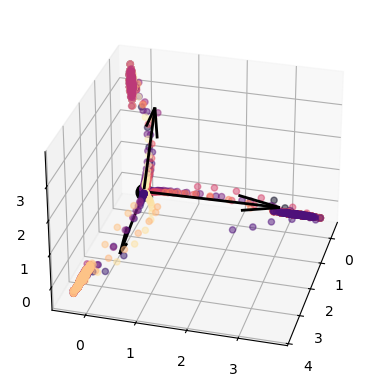

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a few points for each neuron
trst = 15000
skp = 500
ax.plot(0, 0, 0, color="k", marker="o", ls="none", ms=12)
colors = sns.color_palette("magma", n_colors=n_neurons)
for i in range(n_neurons):
    ax.scatter(m_ser_alt[trst::skp, i, 0], m_ser_alt[trst::skp, i, 1], m_ser_alt[trst::skp, i, 2], 
               alpha=0.5, color=colors[i], label="Neuron {}".format(i))

# Annotate with vectors representing the odor components
orig = np.zeros([n_dimensions, n_components])
xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
scale = 3
vecs = back_components.copy()
for i in range(n_components):
    vecs[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2)) * scale
ax.quiver(*orig, *(vecs.T), color="k", lw=2.0)
ax.view_init(azim=15, elev=30)
# ax.legend()
plt.show()
plt.close()

#### The alternating inputs case works just fine! 
It's really the continuous character of the fluctuations in my linear mixture model,  which are effectively gaussian around the mean vector, that creates a ring of fixed points around that mean vector. If the distribution was multi-modal, I'm pretty sure the model would only have discrete fixed points. 

# Remark on stability of the steady-state and oscillations
When $\tau_{\Theta}$ is too close to $\frac{1}{\mu}$, the learning time scale, the stable fixed points become unstable via a Hopf bifurcation (Udeigwe, ..., Ermentrout 2017), and oscillations around those foci appear. If $\tau_{\Theta}$ is further increased, the limit cycle also disappears and the solutions just escape to infinity. This result is known for the alternating input case. 

We also see this with our gaussian process for the input. Try the following sequence of parameter values to witness the appearance of small oscillations, then large oscillations, and finally instability. 
``` 
averages_nu = np.ones(n_components)
learnrate = 0.0025; 
tau_avg = 100, 120, 150, 200  # 100 is stable, 120 small oscillations, 150 large, 200 unstable
```
The position of the bifurcations as a function of $\tau_{\Theta}$ also depends on the magnitude of the input fluctuations. A larger $\tau_{\Theta}$ value can still lead to non-oscillatory solutions if the input fluctuations are smaller, controlled by e.g. setting `averages_nu = np.ones(n_components) / np.sqrt(n_components)`. 

I did not explore this phenomenon much more for the moment; the lesson is that if oscillations or divergences appear in the simulations, they can be fixed by decreasing the learning rate (which makes the model convergence slower, though) or decreasing $\tau_{\Theta}$ (which increases the noise around the steady-state, though). Hopefully, that will never become too problematic -- although, note that we are already in a regime where the model is super slow compared to background fluctuations, which is worrying me about the realism of that model. But I don't think any model could do better without sampling the background statistics enough.  Also, note that by initializing the neurons closer to a proper inhibitory state, the convergence could be faster. It might also be faster in higher dimension, because many dimensions remain zero? Not sure. 

# Non-gaussian unimodal distribution
If there is a discrete number of fixed points when the $\nu_{\alpha}$ have a distribution with non-zero third moment, there should be a transition from a continuum of fixed points to this discrete case as we increase a parameter $\epsilon = \langle (\nu - \langle\nu\rangle)^3 \rangle$ above zero. Will it be a first or second order phase transition? We will see. 

My guess is that there is no transition as long as the distribution is unimodal, and then as soon as there are multiple maxima in the pdf of $\nu$, then only discrete fixed points exist. We'll see what happens with a unimodal distribution of non-zero central third moment. 

To interpolate with a parameter $\epsilon$ from a gaussian distribution to a distribution with non-zero central third moment, we could perturb the generating functional of the Ornstein-Uhlenbeck process, however it then becomes hard to return to the stochastic differential equation, and we lose the exact update rule we had for a gaussian process (hence we run in numerical accuracy issues because of a large dt). 

Instead, the trick is to simulate $x$ as an Ornstein-Uhlenbeck process with zero mean, then take
$$ \nu = s + x + \epsilon x^2 $$
or, in the multivariate case, 
$$ \vec{\nu} = \vec{s} + \vec{x} + \epsilon \mathrm{diag}(\vec{x}) \vec{x} $$

If there are no correlations, we can treat each component $\nu_{\alpha}$ as a univariate case, and we then have a third moment of order $\epsilon$, with only lower-order corrections to the second moment and order $\epsilon$ corrections to the desired mean $s$ (which we could correct preemptively):

$$ \langle \nu \rangle = s + \epsilon \sigma^2 $$
$$ \langle (\nu - \langle \nu \rangle)^2 \rangle = \sigma^2 + 2 \epsilon^2 \sigma^4 $$
$$ \langle (\nu - \langle \nu \rangle)^3 \rangle = 6 \epsilon \sigma^4 + 8 \epsilon^3 \sigma^6 $$

In [19]:
# Function to update the fluctuating background variable
def update_thirdmoment_kinputs(x_bk, params_bk, noises, dt):
    """ 
    Update a background made of L odorants with concentrations combined linearly:
        x(t) = \sum_{\alpha} \nu_{\alpha} x_{\alpha}
    The concentrations nu_alpha are given by
        \nu_\alpha = s_\alpha + x_\alpha + \epsilon x_\alpha
    where the $x_\alpha$ fluctuate according to a multivariate
    Ornstein-Uhlenbeck process with some correlation between them. The general update rule is of the form
        \vec{x}(t + dt) = M_A \vec{x}(t) + M_B \vec{n}
    where M_A and M_B are related to the matrix coefficients A and B in the Langevin equation
    as indicated above (exp factors and Cholesky decomposition), and \vec{n} is a vector of 
    independent normal(0, 1) samples. 
    This function is agnostic to A and B and just requires the overall matrix coefficients 
    in front of of x(t) and \vec{n} in the update rule. 
    
    Args:
        x_bk (np.ndarray): array of length K, containing normal processes x_\alpha underlying
            the concentrations \nu_\alpha of odorants in the background
        params_bk (list of arrays): mateA, matJB, vecs_nu, means_nu, epsil: matrices of shape (K, K)
            involved in the update rule and matrix of background component vectors x_{\alpha}, shape (K, d)
            where d is the number of dimensions. Each row is a different component. 
            Also a 1d array of the mean values of the nu variables. They are simulated with zero mean
            and their average is added before the background is computed. 
            epsil is the magnitude of the quadratic contribution to nu. 
        noises: 1d array of pre-generated normal(0, 1) samples, one per component in nu_bk
    """
    # First, update gaussian x
    mateA, matJB, vecs_nu, means_nu, epsil = params_bk
    x_bk_new = np.dot(mateA, x_bk) + np.dot(matJB, noises)
    # Then compute nu
    nu_bk_new = means_nu + x_bk_new + epsil*x_bk_new*x_bk_new
    # Update background vector, putting back the mean value of the nu's
    bkvec = np.squeeze(np.dot(nu_bk_new[np.newaxis, :], vecs_nu))
    
    return bkvec, x_bk_new

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xk/d13rqg5s4rj4gvl0myjd0xbr0000gq/T/ipykernel_42594/2590135397.py:3: SyntaxWarning: invalid escape sequence '\s'
  """


In [20]:
### General simulation parameters
n_dimensions = 3
n_components = 3
n_neurons = 32

# Simulation times
duration = 160000.0
deltat = 1.0
learnrate = 0.0025
tau_avg = 150
coupling_eta = 0.05 / n_neurons

# Initial synaptic weights: small positive noise near origin
rgen_meta = np.random.default_rng(seed=923487)
init_synapses = 0.1*rgen_meta.random(size=[n_neurons, n_dimensions])

# Choose three LI vectors in (+, +, +) octant
back_components = 0.1*np.ones([n_components, n_dimensions])
for i in range(n_components):
    if i < n_dimensions:
        back_components[i, i] = 0.8
    else:
        back_components[i, i % n_dimensions] = 0.8 - i
    # Normalize
    back_components[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2))

# Initial background vector and initial nu values
averages_nu = np.ones(n_components) / np.sqrt(n_components)
init_nu = np.zeros(n_components)
init_bkvec = np.squeeze(averages_nu[np.newaxis, :].dot(back_components))
# nus are first in the list of initial background params
init_back_list = [init_nu, init_bkvec]

## Compute the matrices in the Ornstein-Uhlenbeck update equation
# Update matrix for the mean term: 
# Exponential decay with time scale tau_nu over time deltat
tau_nu = 2.0  # Fluctuation time scale of the background nu_alphas (same for all)
update_mat_A = np.identity(n_components)*np.exp(-deltat/tau_nu)

# Steady-state covariance matrix
sigma2 = 0.09
correl_rho = 0.3
epsilon_nu = 0.2
steady_covmat = correl_rho * sigma2 * np.ones([n_components, n_components])  # Off-diagonals: rho
steady_covmat[np.eye(n_components, dtype=bool)] = sigma2  # diagonal: ones

# Cholesky decomposition of steady_covmat gives sqrt(tau/2) B
# Update matrix for the noise term: \sqrt(tau/2(1 - exp(-2*deltat/tau))) B
psi_mat = np.linalg.cholesky(steady_covmat)
update_mat_B = np.sqrt(1.0 - np.exp(-2.0*deltat/tau_nu)) * psi_mat

back_params_3 = [update_mat_A, update_mat_B, back_components, averages_nu, epsilon_nu]

In [21]:
sim_res = integrate_ibcm_network(init_synapses, update_thirdmoment_kinputs, init_back_list, back_params_3, 
            duration, deltat, learnrate, seed=98877742, noisetype="normal", tavg=tau_avg, coupling=coupling_eta)

t_ser, m_ser, bk_ser, c_ser, cbar_ser, bkvec_ser = sim_res

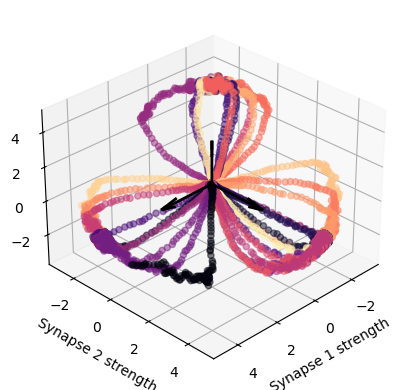

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a few points for each neuron
trst = 150
skp = 1000
ax.plot(0, 0, 0, color="k", marker="o", ls="none", ms=12)
colors = sns.color_palette("magma", n_colors=n_neurons)
for i in range(n_neurons):
    ax.scatter(m_ser[trst::skp, i, 0], m_ser[trst::skp, i, 1], m_ser[trst::skp, i, 2], 
               alpha=0.5, color=colors[i], label="Neuron {}".format(i))

# Annotate with vectors representing the odor components
orig = np.zeros([n_dimensions, n_components])
xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
scale = 3
vecs = back_components.copy()
for i in range(n_components):
    vecs[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2)) * scale
ax.quiver(*orig, *(vecs.T), color="k", lw=2.0)
ax.view_init(azim=45, elev=30)
ax.set(xlabel="Synapse 1 strength", 
      ylabel="Synapse 2 strength", 
      zlabel="Synapse 3 strength")
# ax.view_init(azim=45, elev=140)
# ax.legend()
#fig.savefig("figures/three_odors/neurones_ibcm_fond_non-gaussien_3_odeurs.png", 
#            transparent=True, bbox_inches="tight", dpi=400)
plt.show()
plt.close()